The second example notebook introduces a more complex use case, in that it deals with the simultaneous inference of the drift and diffusion functions. The necessary data is provided in the form of perturbed mean exit time values from the "Landau-Stuart process", which comprises a cubic drift and quadratic diffusion function. As of now, the computations are restricted to one-dimensional spacial domains.

The presented steps include data generation, linearized inference, MCMC sampling and the visualization of the results.

In [1]:
import os
import numpy as np

from sp_inference import processes, model, sampling, postprocessing, logging

The configuration is centered around python dictionaries and numpy data structures. Most dictionaries serve as direct input for the library components, whereas the remaining dicts are just for concise representation of the settings.

In [2]:
# Settings of the logger, which is shared by all library components
# The data is saved into a pre-defined file structure to reduce the number of settings
logSettings = {
    # Output folder; if None is specified, no data is saved
    "output_directory":     "02_example_stationary",
    # Decides if log info is printed to the screen
    "verbose":              True
}

# Settings for the generation of data from a prototypical stochastic process
dataSettings = {
    # Process type, check the 'processes' module for options
    "process_type":         "Dr31Di21Process",
    # Parameter(s) for the drift function (cubic and quadratic terms for Landau-Stuart process)
    "drift_parameters":     [2, 3],
    # Parameter(s) for the diffusion function (quadratic and linear for Landau-Stuart process)
    "diffusion_parameters": [1, 2],
    # Standard deviation of the zero-centered Gaussian noise on the generated data
    "standard_deviation":   0.01,
    # RNG seed for data point generation
    "rng_seed":             0,
    # Number of data points to generate
    "num_points":           50,
    # Spacial domain on which to compute data (here for the mean exit time)
    "domain_bounds":        [-1, 1]
}
# Settings for the inference model
modelSettings = {
    # Which parameter(s) to infer, can be 'drift', 'diffusion', or 'all'
    "params_to_infer":      "all",
    # Model type describing the PDE constraint of the inference problem and source of the data.
    # For options have a look at the implemented 'forms' in the 'pde_problems' module
    "model_type":           "mean_exit_time",
    # Determines if the underlying pde problem is treated as stationary or transient
    # All models can possibly be made transient, but for e.g. the mean exit time problem this would
    # lead to errornous results.
    "is_stationary":        True
}

# Settings of the Bi-Laplacian prior transferred from the hIPPYlib library
priorSettings = {
    # Mean function (for drift and diffusion)
    "mean_function":        [lambda x: -0.5*x, lambda x: 1.5*np.ones(x.size)],
    # Parameter for the covariance operator
    "gamma":                1,
    # Parameter for the covariance operator
    "delta":                1,
    # Determines if Robin boundary conditions are used for the computation of the covariance field
    "robin_bc":             False
}

# Settings for the FEM solver of the PDE constraint used for the inference problem
feSettings = {
    # Number of mesh points
    "num_mesh_points":      200,
    # Locations of the spacial domain boundaries
    "boundary_locations":   [-1, 1],
    # Dirichlet boundary values (homogeneous for mean exit time problem)
    "boundary_values":      [0, 0],
    # FEM element degrees for PDE solution (+ adjoint) and parameter function
    "element_degrees":      [1, 1]
}

# Settings of the solver for the linearized inference problem (MAP).
# This is an inexact Newton-CG solver with Armijo line search for globalization
solverSettings = {
    # Relative termination tolerance in the objective functional gradient norm
    "rel_tolerance":         1e-6,
    # Relative termination tolerance in the objective functional gradient norm
    "abs_tolerance":         1e-12,
    # Maximum number of iterations
    "max_iter":              50,
    # Number of Gauss Newton iterations before switching to Newton
    "GN_iter":               5,
    # Armijo constant for sufficient reduction
    "c_armijo":              1e-4,
    # Maximum number of backtracking iterations during line search
    "max_backtracking_iter": 10
}

# Settings for the construction of the reduced Hessian of the linearized problem about the MAP
hessianSettings = {
    # Number of generalized eigenvalue/-vector pairs to include
    "num_eigvals":           10,
    # Number of value to oversample for robustness of the randomized algorithm
    "num_oversampling":      10
}

# Settings for the setup of the MCMC sampler
samplerSettings = {
    # Algorithm type, available options are 'MALA' (gradient informed) and 'pCN' (random walk)
    "algorithm":             'MALA',
    # Determines if the MAP estimate is utilized for sampling, highly recommended
    "use_gr_posterior":      True,
    # Step size of the MALA sampler, this setting is called 'Beta' for the pCN sampler
    "StepSize":              0.1
}

# Settings for a sampler run
samplingRunSettings = {
    # Number of overall samples to produce, including burn-in
    "NumSamples":            1000,
    # Number of burn-in samples (discarded)
    "BurnIn":                100,
    # Variance for the random generation of the initial sample (if none is provided)
    "init_variance":         0.1,
    # RNG seed for the random generation of the initial sample (if none is provided)
    "init_seed":             0
}

# Postprocessing settings
visualizationSettings = {
    # Determines if plots are shown in the notebook
    "show":                  True,
    # Lag over which to evaluate the quantity of interest (QOI) from the MCMC run. If not defined
    # otherwise, the QOI is the Lebesgue norm of the parameter function over the defined domain.
    "qoi_lag":               100
}

In [3]:
try:
    os.system('rm -r ' + logSettings["output_directory"])
except:
    pass

# The logger is instantiated as a separate object that is passed to other components
logger = logging.Logger(logSettings["verbose"],
                        logSettings["output_directory"])

rm: das Entfernen von '02_example_stationary' ist nicht möglich: Datei oder Verzeichnis nicht gefunden


We firstly create artificial data from a prototypical stochastic process. The spacial locations of the data points are passed to the generating routine for higher flexibility. The data is generated by superimposing zero-centered Gaussian noise to the exact value of the generating model, here the solution of the process's mean exit time problem. The resulting data is used for the definition of the misfit functional of the inference problem.


In [4]:
randGenerator = np.random.default_rng(dataSettings["rng_seed"])
randLocs = randGenerator.uniform(*dataSettings["domain_bounds"], dataSettings["num_points"])
dataSettings["domain_points"] = randLocs

processType = processes.get_process(dataSettings["process_type"])
process = processType(dataSettings["drift_parameters"],
                      dataSettings["diffusion_parameters"],
                      logger)

# Generating function returns exact and perturbed data
forwardNoisy, forwardExact = process.generate_data(modelSettings["model_type"],
                                                   modelSettings["is_stationary"],
                                                   dataSettings)

exactDrift = process.compute_drift(randLocs)
exactDiffusion = process.compute_squared_diffusion(randLocs)
exactParamValues = np.column_stack((exactDrift, exactDiffusion))

exactParamData = [randLocs, exactParamValues]
randForwardData = [randLocs, forwardNoisy]
exactForwardData = [randLocs,  forwardExact]

# New settings dict for the misfit functional
misFitSettings = {
    "data_locations": randLocs,
    "data_values": forwardNoisy,
    "data_std": dataSettings["standard_deviation"]
}

================== Invoke Dr31Di21Process ==================
 
Drift Coefficient(s): [2, 3] 
Diffusion Coefficient(s): [1, 2] 

Generate MET data:                 Successful 



The inference model simply takes settings for the overall model, its prior, the FEM setup and the misfit.

In [5]:
inferenceModel = model.SDEInferenceModel(modelSettings,
                                         priorSettings,
                                         feSettings,
                                         misFitSettings,
                                         logger=logger)

# Get drift/diffusion mean and variance, along with mean exit time solution when using prior info
priorMeanData, priorVarianceData, priorForwardData = inferenceModel.get_prior_info("Randomized")

================== Invoke Inference Model ==================
 
Construct PDE Problem:             Successful 

Construct Prior:                   Successful 

Construct Misfit:                  Successful 

 


An optimization routine computes the maximum a posteriori (MAP) estimate for the linearized problem. The algorithm employs a second order inexact Newton-CG algorithm to find the optimum. As a result, it returns the MAP point along with the reduced Hessian at that point (only considering a limited number of dominating eigenvalue-eigenvector pairs).

In [6]:
# Data for mean, variance and forward solution is returned in form of x-y-value pairs over the spacial domain
mapMeanData, mapVarianceData, mapForwardData, hessEigVals \
    = inferenceModel.compute_gr_posterior(solverSettings, hessianSettings)

=============== Conduct Linearized Inference ===============
 
Solve for MAP: 

It  cg_it cost            misfit          reg             (g,dm)          ||g||L2        alpha          tolcg         
  1   1    3.202302e+03    3.201767e+03    5.346260e-01   -4.891404e+04   6.101465e+04   1.000000e+00   5.000000e-01
  2   1    2.427873e+02    2.409113e+02    1.875993e+00   -6.278349e+03   9.118097e+03   1.000000e+00   3.865761e-01
  3   1    6.516224e+01    6.249894e+01    2.663298e+00   -3.544904e+02   1.286176e+03   1.000000e+00   1.451888e-01
  4   3    4.958619e+01    3.171179e+01    1.787440e+01   -6.414191e+01   2.211982e+02   1.000000e+00   6.021070e-02
  5   2    3.896848e+01    2.137030e+01    1.759818e+01   -2.233262e+01   2.485793e+02   1.000000e+00   6.382862e-02
  6   4    3.897119e+01    2.136890e+01    1.760230e+01   -5.237643e+00   6.973476e+01   9.765625e-04   3.380707e-02

Not Converged 
Termination reason:                Maximum number of backtracking reached 
Final gr

The data is visualized conveniently through pre-defined plotting routines that have access to a small data base of figure annotation infos. Settings dictionaries serve as input for the postprocessor.


 
=================== Invoke Postprocessor ===================
 
Visualize Hessian Data 



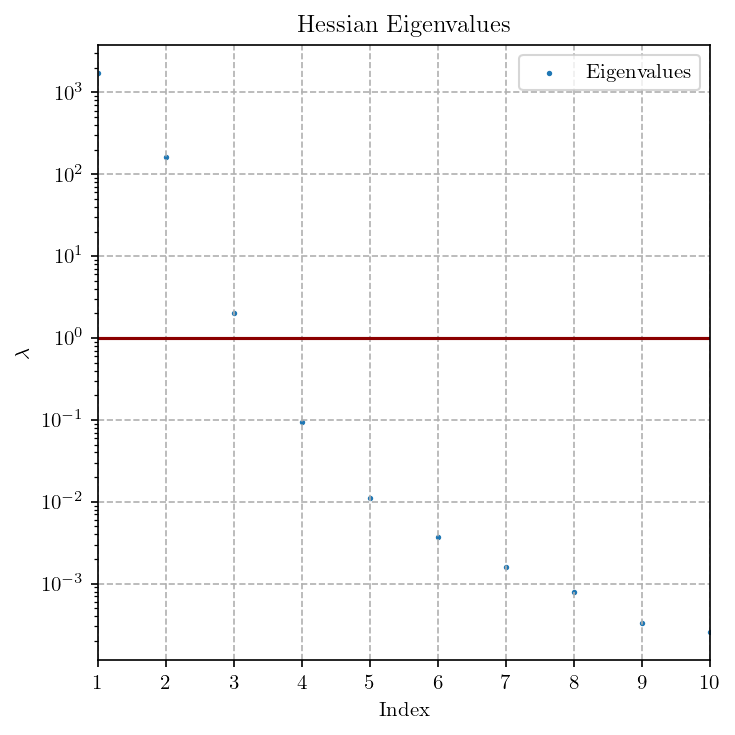

Visualize Parameter Functions, mode='linearized' 



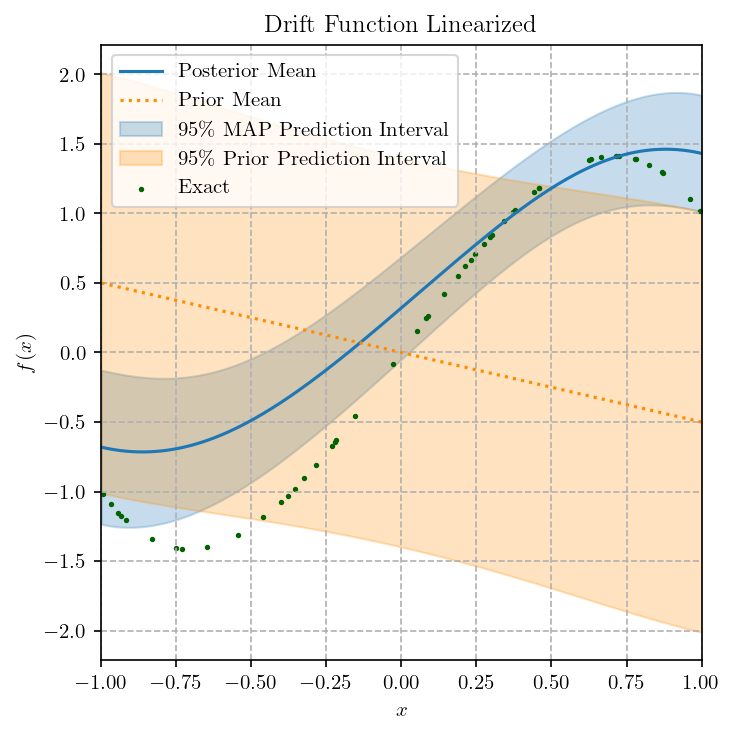

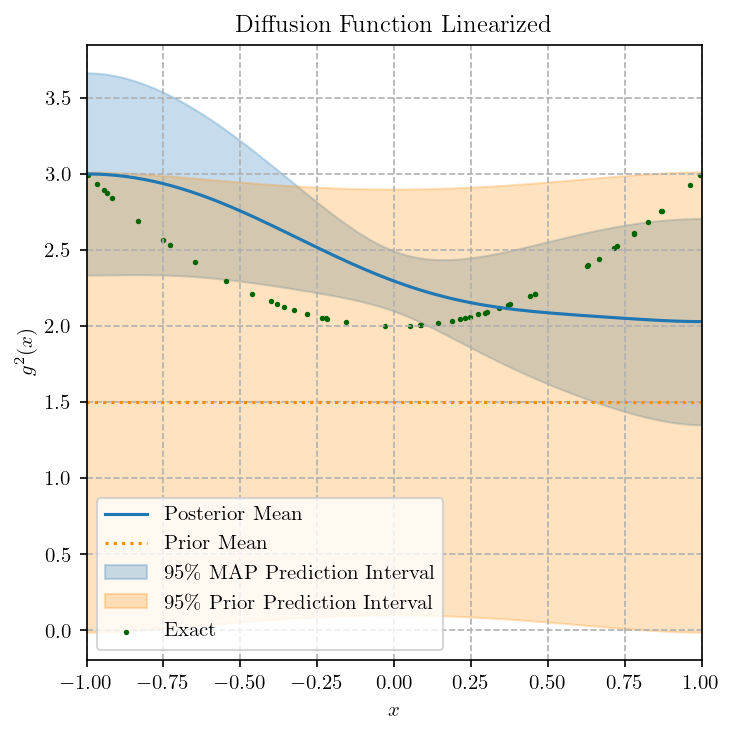

Visualize PDE Solution, mode='linearized' 



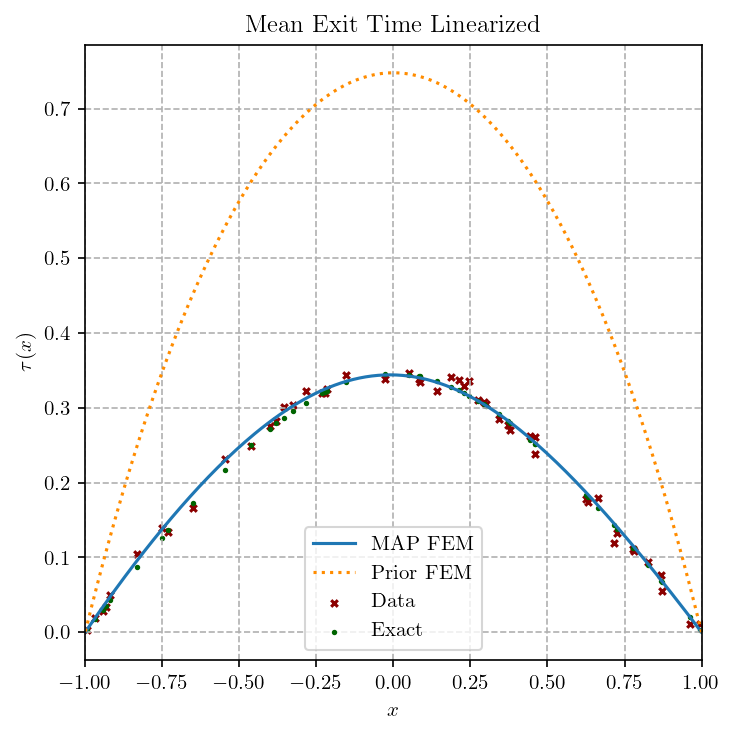

In [7]:
paramData = {"prior_mean": priorMeanData,
             "prior_variance": priorVarianceData,
             "posterior_mean": mapMeanData,
             "posterior_variance": mapVarianceData,
             "exact": exactParamData}

forwardData = {"prior": priorForwardData,
               "posterior": mapForwardData,
               "noisy": randForwardData,
               "exact": exactForwardData}

# The plotting mode is 'linearized' according to the solution procedure
postprocessor = postprocessing.Postprocessor(show=True, logger=logger)
postprocessor.visualize_hessian_data(hessEigVals)
postprocessor.visualize_parameters(paramsInferred=modelSettings["params_to_infer"],
                                   mode="linearized",
                                   data=paramData)                              
postprocessor.visualize_forward_solution(modelType=modelSettings["model_type"],
                                         mode="linearized",
                                         isStationary=modelSettings["is_stationary"],
                                         data=forwardData)

The MCMC sampler is created using the linearized models and the sampler specific settings. It is important that the linearized model has a well-defined posterior, that is has been 'run' successfully. The sampler can then create a sample collection and evaluate the associated QOI. Per default, the QOI is the L2-norm of the parameter function. Different QOIs can be defined as children of the 'BaseQOI' class in the sampling module and passed as an argument to the evaluation method.

In [8]:
sampler = sampling.MCMCSampler(inferenceModel, samplerSettings, logger)
# Data for mean, variance and forward solution is returned in form of x-y-value pairs over the spacial domain
mcmcMeanData, mcmcVarianceData, mcmcForwardData = sampler.run(samplingRunSettings)
qoiTrace = sampler.evaluate_qoi()

 
===================== Invoke Sampling ======================
 
Construct Sampler:                 Successful 

Start Sampling:                    

Starting single chain MCMC sampler...
  10% Complete
    Block 0:
      MHKernel acceptance Rate = 47%
  20% Complete
    Block 0:
      MHKernel acceptance Rate = 46%
  30% Complete
    Block 0:
      MHKernel acceptance Rate = 45%
  40% Complete
    Block 0:
      MHKernel acceptance Rate = 48%
  50% Complete
    Block 0:
      MHKernel acceptance Rate = 47%
  60% Complete
    Block 0:
      MHKernel acceptance Rate = 47%
  70% Complete
    Block 0:
      MHKernel acceptance Rate = 47%
  80% Complete
    Block 0:
      MHKernel acceptance Rate = 48%
  90% Complete
    Block 0:
      MHKernel acceptance Rate = 47%
  100% Complete
    Block 0:
      MHKernel acceptance Rate = 46%
Completed in 38.2167 seconds.
                                                            
Evaluate QOI:                      Successful 


The visualization of the MCMC results works completely analogous to that for the linearized model. In addition, the postprocessor provides capabilities for the analysis of and visualization of the QOI.

 
=================== Invoke Postprocessor ===================
 
Visualize Parameter Functions, mode='mcmc' 



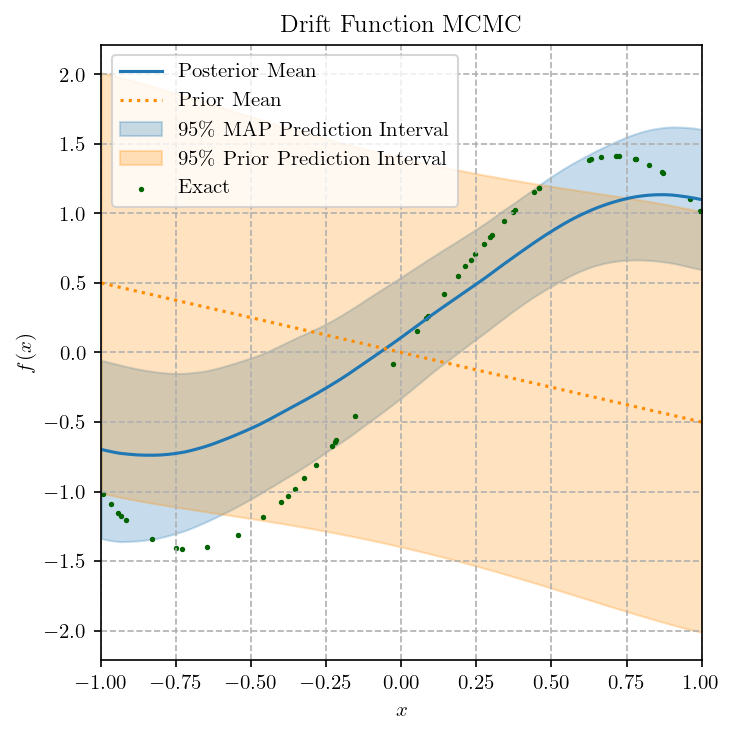

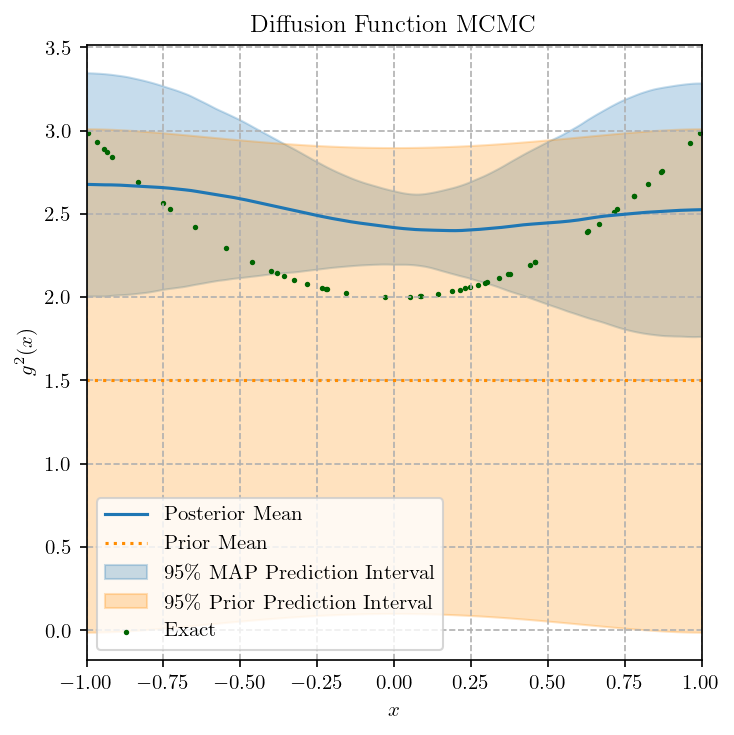

Visualize PDE Solution, mode='mcmc' 



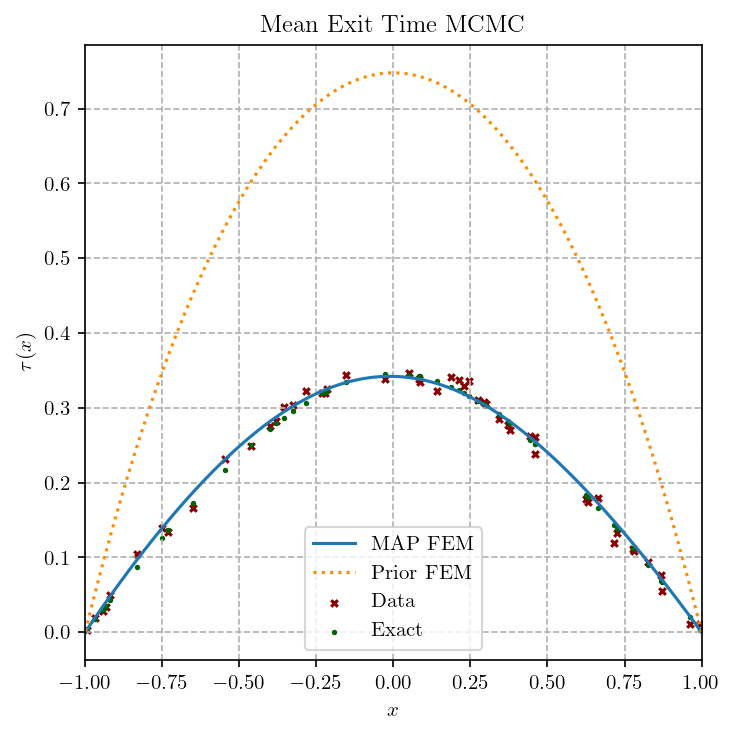

Postprocess QOI Data: 

Mean Value:              13.9   
Autocorrelation length:  55.2   
Effective sample size:   16.3   


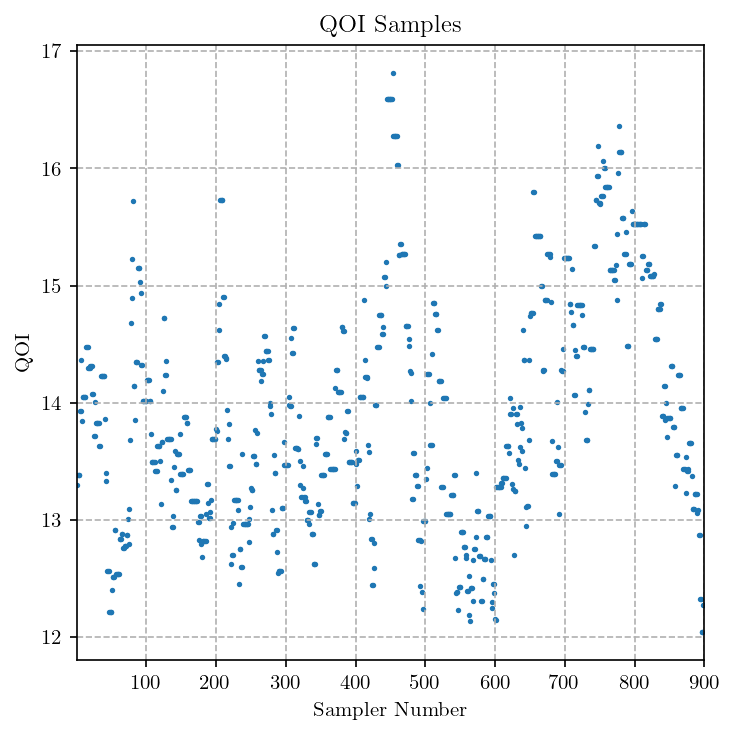

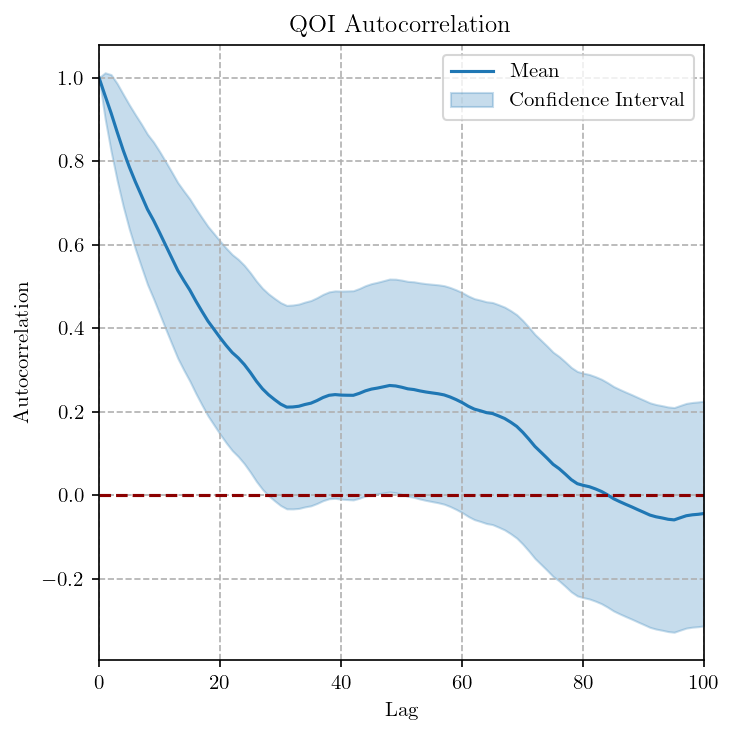

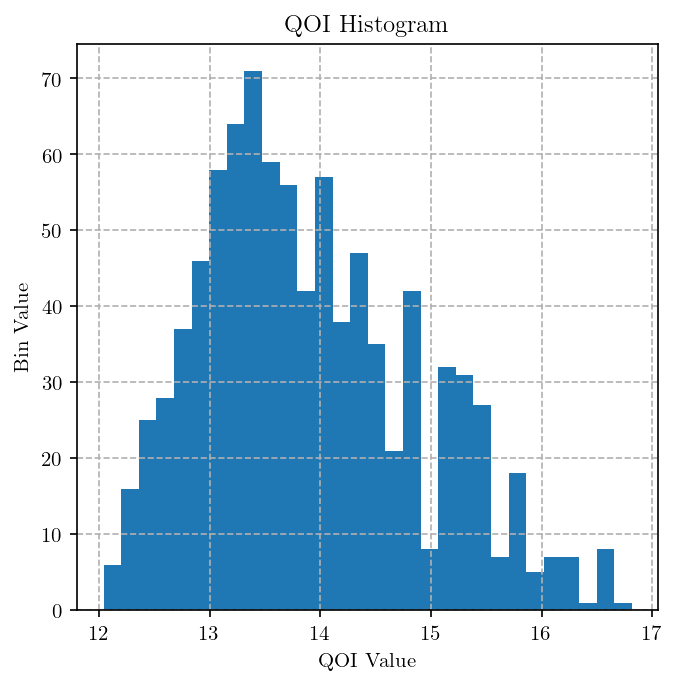

In [9]:
paramData = {"prior_mean": priorMeanData,
             "prior_variance": priorVarianceData,
             "posterior_mean": mcmcMeanData,
             "posterior_variance": mcmcVarianceData,
             "exact": exactParamData}

forwardData = {"prior": priorForwardData,
               "posterior": mcmcForwardData,
               "noisy": randForwardData,
               "exact": exactForwardData}

# The plotting mode is 'linearized' according to the solution procedure
postprocessor = postprocessing.Postprocessor(show=visualizationSettings["show"], logger=logger)
postprocessor.visualize_parameters(paramsInferred=modelSettings["params_to_infer"],
                                   mode="mcmc",
                                   data=paramData)                              
postprocessor.visualize_forward_solution(modelType=modelSettings["model_type"],
                                         mode="mcmc",
                                         isStationary=modelSettings["is_stationary"],
                                         data=forwardData)

# Visualizes QOI values, autocorrelation and creates a histogram
postprocessor.postprocess_qoi(qoiTrace, maxLag=visualizationSettings["qoi_lag"])